In [ ]:
# !pip install pandas
# !pip install numpy
# !pip install pandas
# !pip install pydicom

For this chapter we'll be participating in a real kaggle competition and evaluate each of the regularization techniques of the chapter 7

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import os
import pydicom

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models
import torch.nn as nn

https://www.kaggle.com/seraphwedd18/pe-detection-with-keras-model-creation#Training-Model

In [2]:
train_path = 'E:\\Download\\new_downloads\\train'
csv_path = 'E:\\Download\\new_downloads\\train.csv'
sample_subm_csv_path = 'E:Download\\new_downloads\\sample_submission.csv'

In [3]:
df_train = pd.read_csv(csv_path)

In [4]:
df_train.shape

(1790594, 17)

In [5]:
df_train.head()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,0,1,1,0,0,1,0,0,0
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,0,1,1,0,0,1,0,0,0


In [6]:
df_train.tail()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
1790589,4833c9b6a5d0,57e3e3c5f910,da0ecef50cf5,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790590,4833c9b6a5d0,57e3e3c5f910,d74b46c2f2c4,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790591,4833c9b6a5d0,57e3e3c5f910,ba71189191ad,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790592,4833c9b6a5d0,57e3e3c5f910,f4fdc88f2ace,0,0,0,0,0,0,1,1,1,0,0,0,0,0
1790593,4833c9b6a5d0,57e3e3c5f910,f890efd48940,1,0,0,0,0,0,1,1,1,0,0,0,0,0


In [7]:
sample_csv_df = pd.read_csv(sample_subm_csv_path)

In [8]:
sample_csv_df.shape

(152703, 2)

In [9]:
sample_csv_df.head()

,id,label
0,df06fad17bc3_negative_exam_for_pe,0.5
1,c8039e7f9e63_negative_exam_for_pe,0.5
2,761f6f1a9f5b_negative_exam_for_pe,0.5
3,c8db5b1f6b56_negative_exam_for_pe,0.5
4,462e805da1f1_negative_exam_for_pe,0.5


In [10]:
def read_an_image(image_path):
    '''
    read a .dcm image and convert it to a float numpy array
    '''
    mri_file = open(image_path, 'rb')
    dcm_im = pydicom.read_file(mri_file)
    image_2d = dcm_im.pixel_array.astype(float)
    image_2d_scaled = (np.maximum(image_2d,0) / image_2d.max())
    return image_2d_scaled.astype(np.float32)

def get_an_image(df, idx=0):
        sample_img_path = os.path.join(train_path, df.iloc[idx][0], df.iloc[idx][1], df.iloc[idx][2])+'.dcm'
        img = read_an_image(sample_img_path)
        print('Reading image:', sample_img_path)
        return img

def get_a_random_image(df):
    while True:
        rand_idx = np.random.randint(len(df))
        try:
            img = get_an_image(df, rand_idx)
#             print('getting image with id ', rand_idx)
            return img
            
        except:
            pass

In [11]:
img = get_a_random_image(df_train)

Reading image: E:\Download\new_downloads\train\2e918ce182eb\428145069b5c\c99fa16222c7.dcm


In [12]:
img.shape, img.min(), img.max()

((512, 512), 0.0, 1.0)

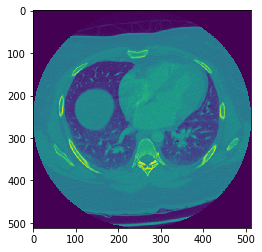

In [13]:
plt.imshow(img)

In [14]:
np.stack((img,)*3, axis=0).shape

(3, 512, 512)

In [15]:
class LungsDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        self.csv_file = csv_file
        self.transform = transform

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):

        img = get_an_image(self.csv_file, idx)
        img = np.stack((img,)*3, axis=-1)
        target = df_train.iloc[idx,3:].to_numpy()
        
        if self.transform:
            img = self.transform(img)
            
        return img, target, idx

In [16]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

ds_trans = transforms.Compose([
                               transforms.ToTensor(),
                               normalize
])

In [17]:
train_dataset = LungsDataset(df_train, transform=ds_trans)

len(train_dataset)

1790594

In [18]:
np.expand_dims(np.stack((img,)*3, axis=0),0).shape

(1, 3, 512, 512)

In [19]:
ds_trans(np.stack((img,)*3, axis=-1)).shape

torch.Size([3, 512, 512])

In [20]:
for i in range(len(train_dataset)):
    try:
        rand_idx = np.random.randint(len(df_train))
        sample, target, idx = train_dataset[rand_idx]
        break
    except:
        print('Error getting image!', i)

Reading image: E:\Download\new_downloads\train\207c2cdf9547\1cb343cead97\7566d4383d16.dcm


In [21]:
def batch_generator(batch_size):
    i = 0
    batch_samples=[]
    while True:
        try:
            rand_idx = np.random.randint(len(df_train))
            sample, target, idx = train_dataset[rand_idx]
            batch_samples.append((sample, target, idx))
            i += 1
        except:
            continue
#             print('Error getting image!', i)
        if i == batch_size:
            break
    return batch_samples

In [22]:
sample.shape, target, idx

(torch.Size([3, 512, 512]),
 array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=object),
 530397)

In [23]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

def show_image(img, denormalize=True):
    if denormalize:
        img = invTrans(img)
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


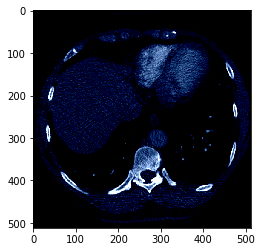

In [24]:
show_image(sample, denormalize=False)

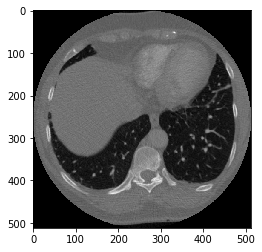

In [25]:
show_image(sample, denormalize=True)

In [26]:
batch_samples = batch_generator(8)

Reading image: E:\Download\new_downloads\train\40c0ac498189\097ef73c742f\12079c13fc76.dcm
Reading image: E:\Download\new_downloads\train\25e3c72ab3f8\c4afaad44487\6d051c2ec898.dcm
Reading image: E:\Download\new_downloads\train\250af6c8ce58\e36dc21975c2\aa111230b353.dcm
Reading image: E:\Download\new_downloads\train\4d7140eaedcd\8684b46634ff\7af1488ee0f4.dcm
Reading image: E:\Download\new_downloads\train\190c26a987bf\49dbe8a5229e\973e343495bd.dcm
Reading image: E:\Download\new_downloads\train\0b085f01d368\1e7811ae9202\a9b98186bc17.dcm
Reading image: E:\Download\new_downloads\train\29d8fb689291\b77d9af9f3ea\16e54c552088.dcm
Reading image: E:\Download\new_downloads\train\5cc491bfaac3\e4ba82403fd0\4d38acab3e7f.dcm


In [27]:
len(batch_samples)

8

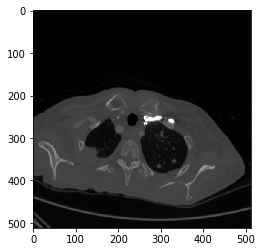

In [28]:
show_image(batch_samples[0][0], denormalize=True)

In [29]:
resnet152 = models.resnet152()

In [30]:
resnet152

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
# classifier = nn.Sequential(
# #             nn.Conv2d(1,20,5),
# #             nn.ReLU(),
# #             nn.Conv2d(20,64,5),
# #             nn.ReLU()
#             nn.Linear(2048, 2048),
#             nn.ReLU(),
#             nn.Linear(2048, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 1)
#         )

In [32]:
class LastBlock(nn.Module):

    def __init__(self):
        super(LastBlock, self).__init__()
        in_features = 2048
        self.liner_pe_present_on_image = nn.Linear(in_features, 1)
        self.liner_negative_exam_for_pe = nn.Linear(in_features, 1)
        self.liner_qa_motion = nn.Linear(in_features, 1)
        self.liner_qa_contrast = nn.Linear(in_features,  1)
        self.liner_flow_artifact = nn.Linear(in_features, 1)
        self.liner_rv_lv_ratio_gte_1 = nn.Linear(in_features, 1)
        self.liner_rv_lv_ratio_lt_1 = nn.Linear(in_features, 1)
        self.liner_leftsided_pe = nn.Linear(in_features,  1)
        self.liner_chronic_pe = nn.Linear(in_features, 1)
        self.liner_true_filling_defect_not_pe = nn.Linear(in_features,  1)
        self.liner_rightsided_pe = nn.Linear(in_features, 1)
        self.liner_acute_and_chronic_pe = nn.Linear(in_features, 1)
        self.liner_rv_lv_ratio_lt_1 = nn.Linear(in_features, 1)
        self.liner_central_pe = nn.Linear(in_features,  1)
        self.liner_indeterminate = nn.Linear(in_features,  1)
        
    def forward(self, x):
        x_pe_present_on_image = self.liner_pe_present_on_image(x)
        x_negative_exam_for_pe = self.liner_negative_exam_for_pe(x)
        x_qa_motion = self.liner_qa_motion(x)
        x_qa_contrast = self.liner_qa_contrast(x)
        x_flow_artifact = self.liner_flow_artifact(x)
        x_rv_lv_ratio_gte_1 = self.liner_rv_lv_ratio_gte_1(x)
        x_rv_lv_ratio_lt_1 = self.liner_rv_lv_ratio_lt_1(x)
        x_leftsided_pe = self.liner_leftsided_pe(x)
        x_chronic_pe = self.liner_chronic_pe(x)
        x_true_filling_defect_not_pe = x_true_filling_defect_not_pe(x)
        x_rightsided_pe = self.liner_rightsided_pe(x)
        x_acute_and_chronic_pe = self.liner_acute_and_chronic_pe(x)
        x_rv_lv_ratio_lt_1 = self.liner_rv_lv_ratio_lt_1(x)
        x_central_pe = self.liner_central_pe(x)
        x_indeterminate = self.liner_indeterminate(x)
        
        
        return x_pe_present_on_image, x_negative_exam_for_pe, x_qa_motion, x_qa_contrast, x_flow_artifact, x_rv_lv_ratio_gte_1, x_rv_lv_ratio_lt_1, x_leftsided_pe, x_chronic_pe, x_true_filling_defect_not_pe, x_rightsided_pe, x_acute_and_chronic_pe, x_rv_lv_ratio_lt_1, x_central_pe, x_indeterminate 
                

resnet152.fc = LastBlock()

In [33]:
df_train.columns

Index(['StudyInstanceUID', 'SeriesInstanceUID', 'SOPInstanceUID',
       'pe_present_on_image', 'negative_exam_for_pe', 'qa_motion',
       'qa_contrast', 'flow_artifact', 'rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1',
       'leftsided_pe', 'chronic_pe', 'true_filling_defect_not_pe',
       'rightsided_pe', 'acute_and_chronic_pe', 'central_pe', 'indeterminate'],
      dtype='object')

In [34]:
resnet152

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 